# Score AI: NLP Essay Scorer

## Why Score AI
Teachers remain stretched thin and under-supported. Automating some of the work they do will help them focus their time and energy on the most important aspects of their work -- building relationships with students that allow them to draw out their best selves. Scoring essays is one of the most time-intensive tasks that a teacher has to do, and the delay in feedback makes it harder for the student to use and internalize that feedback.

## Challenges
- There is a lack of labelled essay data
- There are no straightforward scoring metrics for essay organization
- There are vastly different writing styles and essay lengths
- Good writing transcends formulaic approaches

## Responses
- Scraped data
- Used background knowledge about essay grading to develop a scoring metric
- Chose to only score argumentative essays to start and made scoring length-independent
- Suggest use of scorer only for non-expert writers

## Scraping
Of the dozen or so essay sites that I investigated for scraping, only 2 of them freely offered the entire text of essays without a login. I used a scrapy script within the terminal to run spiders over those two sites to collect essays on about 40 different search terms for popular essay topics and save the necessary information in json files. The scrapy scripts are located in the same Github repo as this project. 

In order to get a ground truth for topic modelling, I used the spiders to scrape tags from the essay pages. Unfortunately, many of the essay tags turned out to be blank or meaningless.

In [1]:
!pip install pyLDAvis

import pandas as pd
import spacy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
import sklearn
import re
import nltk
import pickle
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from gensim.models import CoherenceModel, LsiModel, LdaModel
from string import punctuation
from itertools import starmap, combinations

%matplotlib inline

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
!python -m spacy download en_core_web_md

/content/gdrive/My Drive/Thinkful DS/OrgScorer
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [3]:
# Read in essay data from both sites, concatenate into one data frame
sm_df = pd.read_json('studymoose.json', orient='records')
phd_df = pd.read_json('phdessay.json', orient='records')
raw_df = pd.concat([sm_df, phd_df], ignore_index=True)
len(raw_df)

85190

## Data Cleaning and Preprocessing
The essay texts are not in good shape to be topic modeled and tokenized. Some paragraphs are just newlines, some sentences are too short to be meaningful. Some sentences are citations/references. Essays are too long or contain too many one-sentence paragraphs. I will be removing these all from the dataset because they are interspersed randomly through the data and will not too greatly affect the makeup of the corpus.

In [0]:
# Find text that only newline characters
error_df = raw_df[raw_df['Text'].str.contains('\\n', regex=True)]
error_df = error_df[error_df['Text'].str.len() < 50]
drop_indices = error_df.index.tolist()

In [5]:
# Drop newlines
raw_df.drop(drop_indices, axis=0, inplace=True)
raw_df.reset_index(drop=True, inplace=True)
raw_df.tail()

,Paragraph,Tags,Text,Title,URL
84789,9,"[Change, Affect]",An employer may have to discontinue some insur...,Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...
84790,10,"[Change, Affect]","Mossholder, K. W. , Richardson, H. A. , ; Sett...",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...
84791,11,"[Change, Affect]","California Management Review, 34(2), 9-28. Ret...",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...
84792,12,"[Change, Affect]","Academy of Management Journal, 35(5), 1086-109...",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...
84793,13,"[Change, Affect]",How to Cope When Coworkers Lose Their Jobs. Re...,Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...


In [0]:
# Split each paragraph into sentences
sentences = raw_df.Text.str.split(r'[.!?] ', expand=True)

In [7]:
# Create a sentence-level data frame by joining the sentences to the raw_df
sent_df = raw_df.drop('Text', axis=1).join(
    sentences.stack().reset_index(drop=True, level=1).rename('Text'))
sent_df.head()

,Paragraph,Tags,Title,URL,Text
0,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Let’s first begin with “what is climate change...
0,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Climate change is caused by several factors [2]:
1,2,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,* Internal forcing mechanism (Natural processe...
2,3,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"Since the formation of Earth, our planet’s cli..."
3,4,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,The average temperature of the Earth’s surfac...


In [8]:
# Remove lines that are too short
short_df = sent_df[sent_df['Text'].str.len() < 15]
short_indices = short_df.index.tolist()
sent_df.drop(short_indices, axis=0, inplace=True)

# Reset index
sent_df.reset_index(drop=True, inplace=True)
sent_df.tail()

,Paragraph,Tags,Title,URL,Text
243715,5,"[Change, Affect]",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...,Searching for a new place of employment to red...
243716,5,"[Change, Affect]",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...,"According to Heathfield, S, M (2010) “Research..."
243717,5,"[Change, Affect]",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...,” Employees could be fearful to be unemployed ...
243718,5,"[Change, Affect]",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...,Child care expenses could include child suppor...
243719,5,"[Change, Affect]",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...,Child care expenses and bill payments is essen...


In [9]:
# Remove lines that have too much punctuation (90% citations)
ref_indices = []
for i in range(len(sent_df)):
    text = sent_df.iloc[i, 4]
    punct = [c for c in text if c in punctuation]
    ratio = len(punct) / len(text)
    if ratio > 0.1:
        ref_indices.append(i)
        
sent_df.drop(ref_indices, axis=0, inplace=True)
len(sent_df)

241287

In [10]:
# Count the sentences
sent_df['Sentences'] = sent_df.groupby(
    ['URL', 'Paragraph'])['Text'].transform('count')

sent_df.head()

,Paragraph,Tags,Title,URL,Text,Sentences
0,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Let’s first begin with “what is climate change...,2
1,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Climate change is caused by several factors [2]:,2
2,2,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,* Internal forcing mechanism (Natural processe...,1
3,3,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"Since the formation of Earth, our planet’s cli...",1
4,4,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,The average temperature of the Earth’s surfac...,4


In [11]:
# Remove essays that are too long
long_essays = sent_df[sent_df['Paragraph']>=66]['URL'].unique().tolist()
sent_df = sent_df[~sent_df['URL'].isin(long_essays)]
len(sent_df)

221770

In [12]:
# Number each essay
essays = sent_df.URL.unique()
essay_dict = dict(zip(essays, range(len(essays))))


# Create an Essay column with the number of each essay
sent_df['Essay'] = sent_df['URL'].replace(essay_dict)
sent_df.reset_index(drop= True, inplace=True)
sent_df.tail()

,Paragraph,Tags,Title,URL,Text,Sentences,Essay
221765,5,"[Change, Affect]",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...,Searching for a new place of employment to red...,5,7401
221766,5,"[Change, Affect]",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...,"According to Heathfield, S, M (2010) “Research...",5,7401
221767,5,"[Change, Affect]",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...,” Employees could be fearful to be unemployed ...,5,7401
221768,5,"[Change, Affect]",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...,Child care expenses could include child suppor...,5,7401
221769,5,"[Change, Affect]",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...,Child care expenses and bill payments is essen...,5,7401


In [13]:
# Find essays that have too many one sentence paragraphs
choppy_essays = []
for i, grp in sent_df.groupby('Essay'):
    short_paras = grp[grp['Sentences']==1]
    paras = grp['Paragraph'].unique().tolist()
    if len(short_paras) / len(paras) > 0.5:
        choppy_essays.append(i)
    
len(choppy_essays)

565

In [14]:
# Remove essays that have too many one sentence paragraphs

choppy_indices = sent_df[sent_df['Essay'].isin(choppy_essays)].index.tolist()

sent_df.drop(choppy_indices, inplace=True)

len(sent_df)

212252

In [15]:
# Remove remaining one sentence paragraphs
one_liners = sent_df[sent_df['Sentences']==1].index.tolist()

sent_df.drop(one_liners, inplace=True)

len(sent_df)

203030

In [16]:
# Number each essay
essays = sent_df.URL.unique()
essay_dict = dict(zip(essays, range(len(essays))))


# Create an Essay column with the number of each essay
sent_df['Essay'] = sent_df['URL'].replace(essay_dict)
sent_df.reset_index(drop= True, inplace=True)
sent_df.tail()

,Paragraph,Tags,Title,URL,Text,Sentences,Essay
203025,5,"[Change, Affect]",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...,Searching for a new place of employment to red...,5,6836
203026,5,"[Change, Affect]",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...,"According to Heathfield, S, M (2010) “Research...",5,6836
203027,5,"[Change, Affect]",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...,” Employees could be fearful to be unemployed ...,5,6836
203028,5,"[Change, Affect]",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...,Child care expenses could include child suppor...,5,6836
203029,5,"[Change, Affect]",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...,Child care expenses and bill payments is essen...,5,6836


In [0]:
# Find the paragraphs per essay and sentences per paragraph
maxima = sent_df.groupby('Essay')['Paragraph'].max()

sents_per_para = sent_df.Sentences.value_counts().to_dict()

sents_per_para = {k: int(v/k) for k, v in sents_per_para.items()}

s_counts = [v for v in sents_per_para.values()]


## Distributions of Essay Length
From the plots above, it is easy to see that there is no standard size for essays in terms of the number of paragraphs in the essay or the number of sentences in a paragraph. After exploring the distribution of paragraphs that are one sentence long and the essays that are highly composed of one sentence paragraphs, I decided to remove them from the data set. I believe I can do so without significantly impacting the performance of my model. 

Removal of one sentence paragraphs and essays with a high percentage of on e sentence paragraphs in this model stems from the data collection process. I believe many of the one sentence paragraph to be a result of delineating paragraphs based on the html paragraph tag. In future iterations of this model where essay are collected from users, one sentence paragraphs will be scored at a z-score of -3.

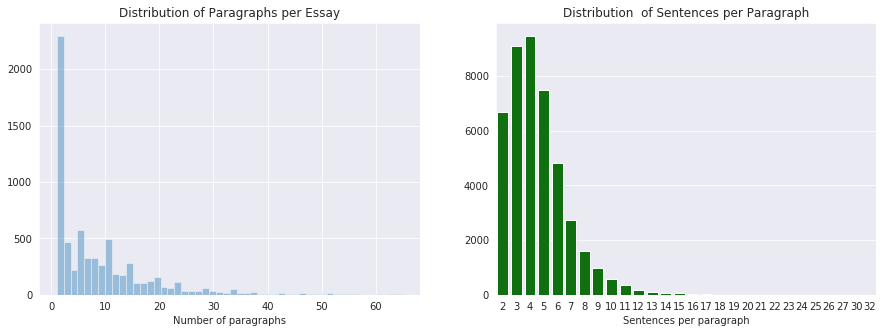

Paragraphs per Essay:
Mean -- 8.962995465847595
Median -- 6.0


Sentences per Para:
Mean -- 4.574499245206498
Median -- 4.0




In [18]:
# Visualize distributions of paragraphs and sentences per para
sns.set_style('darkgrid')

plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.distplot(maxima, 
             kde=False,
             norm_hist=False)
plt.title('Distribution of Paragraphs per Essay')
plt.xlabel('Number of paragraphs')

plt.subplot(122)
sns.barplot([k for k in sents_per_para.keys()], 
            s_counts, 
            color='green')
plt.title('Distribution  of Sentences per Paragraph')
plt.xlabel('Sentences per paragraph')

plt.show()

print('Paragraphs per Essay:\nMean -- {}\nMedian -- {}\n\n'.format( 
maxima.mean(), maxima.median()))

s_list = []
for i in range (1, 33):
  if i in sents_per_para.keys():
    for j in range(sents_per_para[i]):
      s_list.append(i)

s_mean = np.mean(s_list)
mid = len(s_list)//2
s_median = (s_list[mid] + s_list[mid-1]) / 2


print('Sentences per Para:\nMean -- {}\nMedian -- {}\n\n'.format( 
    s_mean, s_median))


## Tokenizing and Topic Modeling

### Spacy Tokens
Since the model depends on the cosine similarity of sentence vectors, I needed to use one of the larger spacy tokenizers. I needed part of speech tags to get only semantically substantive words for topic modeling, but I could disable the dependency parser and named entity recognizer to cut down on memory usage and processing time.

### Topic Modeling
I used the gensim package for topic modeling predominantly for its CoherenceModel implementation that would help me visualize how well the topic models describe the corpus.

In [19]:
# Load spacy model for tokenizing
try:
    with open('essays.pickle', 'rb') as fp:
        tokenized_sents = pickle.load(fp)
    print('Pretrained Model loaded!')
  
except:
    nlp = spacy.load(
        'en_core_web_md', 
        disable=['parser', 'ner'])
    
    # Run NLP to get tokens
    tokenized_sents = []
    i = 0
    for sent in sent_df.Text.tolist():
        i += 1
        if i % 5000 == 0:
            print('Processing {}'.format(i))
        doc = nlp(sent)
        # Get lemmas for each word
        tokenized_sents.append(doc)
    
    with open('essays.pickle', 'wb') as fp:
        pickle.dump(tokenized_sents, fp)
    
    print('New model trained!')

Pretrained Model loaded!


In [20]:
# Set sent_df Text column to tokenized sentences
sent_df['Text'] = tokenized_sents
sent_df.head()

,Paragraph,Tags,Title,URL,Text,Sentences,Essay
0,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"(Let, ’s, first, begin, with, “, what, is, cli...",2,0
1,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"(Climate, change, is, caused, by, several, fac...",2,0
2,4,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"( , The, average, temperature, of, the, Earth,...",4,0
3,4,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"(Global, warming, [, 4, ], –, a, direct, conse...",4,0
4,4,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"(The, “, credit, ”, for, the, “, greatest, con...",4,0


In [0]:
# Group texts by essay to send essays through as documents for the corpus
essays = sent_df.groupby('Essay')['Text'].apply(lambda x: list(x))

In [0]:
# Extract only substantive words for topic modeling
essay_lemmas = []
for essay in essays:
    essay_lemmas.append([x.lemma_ for e in essay for x in e 
                       if not x.is_punct and 
                       x.pos_ in ['PRON', 'NOUN', 'VERB', 'ADJ'] and 
                       x.lemma_ not in ['be', 'have', 'do']])


In [23]:
# Create Dictionary
id2word = corpora.Dictionary([essay_lemmas[0]])

# Add the rest of the essays to the dictionary
for i in range(1, len(essays)):
    try:
        id2word.add_documents([essay_lemmas[i]])
    except:
        print('Error: {}'.format(i))
    if i % 500 == 0:
        print('Processed line {}'.format(i))
        
# Create Corpus
texts = []
for essay in essay_lemmas:
    texts.append([e for e in essay])

# Term Document Frequency
corpus = []
for i in range(len(texts)):
    try:
        corpus.append(id2word.doc2bow(texts[i]))
    except:
        print('Error: {}'.format(i))

# View
print(corpus[:1])

Processed line 500
Processed line 1000
Processed line 1500
Processed line 2000
Processed line 2500
Processed line 3000
Processed line 3500
Processed line 4000
Processed line 4500
Processed line 5000
Processed line 5500
Processed line 6000
Processed line 6500
[[(0, 17), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 5), (25, 1), (26, 1), (27, 5), (28, 4), (29, 2), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 3), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 3), (79, 1), (80, 2), (81, 1), (82, 1), (

In [0]:
def get_lda_model(num_topics):
  '''Trains an LDA model and outputs model and list of information 
  to be used for model info data frame that will be useful for 
  selecting best topic model'''
  
    model_type = 'LDA'
    model_name = 'checkpoints/lda' + str(num_topics) + '.model'
  
    try:
        return LdaModel.load(model_name), [model_type, num_topics]
    
    except:
        print('Training new LDA {} Model'.format(num_topics))
        # Build LDA model
        lda_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=num_topics,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
        # Save model
        lda_model.save(model_name)
    
    return lda_model, [model_type, num_topics]

In [25]:
# Get LDA Models
lda12_model, lda12_info = get_lda_model(num_topics=12)
lda16_model, lda16_info = get_lda_model(num_topics=16)
lda20_model, lda20_info = get_lda_model(num_topics=20)
lda22_model, lda22_info = get_lda_model(num_topics=22)
lda24_model, lda24_info = get_lda_model(num_topics=24)
lda26_model, lda26_info = get_lda_model(num_topics=26)
lda28_model, lda28_info = get_lda_model(num_topics=28)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def get_lsa_model(num_topics):
  '''Trains an LSA model and outputs model and list of information 
  to be used for model info data frame that will be useful for 
  selecting best topic model'''
  
    model_type = 'LSA'
    model_name = 'checkpoints/lsa' + str(num_topics) + '.model'
  
    try:
        return LsiModel.load(model_name), [model_type, num_topics]
    
    except:
        print('Training new LSA {} Model'.format(num_topics))

        # Build LSA Model
        lsa_model = LsiModel(corpus=corpus,
                        id2word=id2word,
                        num_topics=num_topics, 
                        chunksize=100)

        lsa_model.save(model_name)
    
    return lsa_model, [model_type, num_topics]

In [27]:
# Get LSA Models
lsa12_model, lsa12_info = get_lsa_model(num_topics=12)
lsa16_model, lsa16_info = get_lsa_model(num_topics=16)
lsa20_model, lsa20_info = get_lsa_model(num_topics=20)
lsa22_model, lsa22_info = get_lsa_model(num_topics=22)
lsa24_model, lsa24_info = get_lsa_model(num_topics=24)
lsa26_model, lsa26_info = get_lsa_model(num_topics=26)
lsa28_model, lsa28_info = get_lsa_model(num_topics=28)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def get_model_info(df, topic_model, model_type, n_topics, corpus):
  '''Add LDA and LSA model information to a data frame 
  in order to compare, plot, and select the best model'''
  
    print('Getting model info for {} {}'.format(model_type, n_topics))
  
    # Add model info to dataframe
    model = model_type
    n = n_topics
    topics = topic_model.print_topics(num_topics=n_topics)
    if model == 'LDA':
        perplexity = topic_model.log_perplexity(corpus)
    else:
        perplexity = 'N/A'

    coherence_model = CoherenceModel(model=topic_model,
                                      texts=texts, 
                                      dictionary=id2word, 
                                      coherence='c_v')

    coherence = coherence_model.get_coherence()

    return pd.concat([df, 
                    pd.DataFrame.from_dict({'Model Type': model, 
                                            'Num_Topics': n, 
                                            'Topics': topics, 
                                            'Perplexity': perplexity, 
                                            'Coherence': coherence})], 
                   ignore_index=True)
  

In [29]:
# Retrieve model_info data frame or create a new one
try:
    model_info = pd.read_csv('model_info.csv')
  
except:
  
    models = [[lda12_model, lda12_info], 
            [lda16_model, lda16_info], 
            [lda20_model, lda20_info], 
            [lda22_model, lda22_info], 
            [lda24_model, lda24_info], 
            [lda26_model, lda26_info], 
            [lda28_model, lda28_info], 
            [lsa12_model, lsa12_info], 
            [lsa16_model, lsa16_info], 
            [lsa20_model, lsa20_info], 
            [lsa22_model, lsa22_info], 
            [lsa24_model, lsa24_info], 
            [lsa26_model, lsa26_info], 
            [lsa28_model, lsa28_info]]

    model_info = pd.DataFrame(columns=['Model Type', 
                                   'Num_Topics', 
                                   'Topics', 
                                   'Perplexity', 
                                   'Coherence'])

    for model in models:
        model_info = get_model_info(model_info, 
                                model[0], 
                                model[1][0], 
                                model[1][1], 
                                corpus=corpus)
    
    model_info.to_csv('model_info.csv')

model_info.head()

,Unnamed: 0,Model Type,Num_Topics,Topics,Perplexity,Coherence
0,0,LDA,12,"(0, '0.010*""forest"" + 0.010*""begin"" + 0.009*""w...",-8.164028,0.498486
1,1,LDA,12,"(1, '0.022*""law"" + 0.014*""state"" + 0.014*""crim...",-8.164028,0.498486
2,2,LDA,12,"(2, '0.020*""change"" + 0.015*""culture"" + 0.013*...",-8.164028,0.498486
3,3,LDA,12,"(3, '0.041*""social"" + 0.027*""medium"" + 0.025*""...",-8.164028,0.498486
4,4,LDA,12,"(4, '0.056*""water"" + 0.014*""use"" + 0.011*""solu...",-8.164028,0.498486


## Comparing Topic Models
LDA will achieve different results with each model because of the random weight initiation, but through 10 different versions of these LDA models, there was always a peak at 16, a relatively similar peak at 22 and an upward trend from 26 to 28 -- all hovering around 0.50 coherence. While the LSA models do not perform as well, they seem to confirm a peak at 16. 

Prior to having run any topic models, my mentor and I discussed how many topics we might expect. There were 40 search terms, but many of them could be lumped into similar topics or were even synonyms to try to capture more essays about the same topic. We determined that there were about 16 topics and were surprised to see that intuition confirmed by the topic models. Though other numbers of topics for LDA may produce similar or better coherences, we decided to go with the consensus of two different modeling functions and human expertise to use the LDA16 model going forward.  

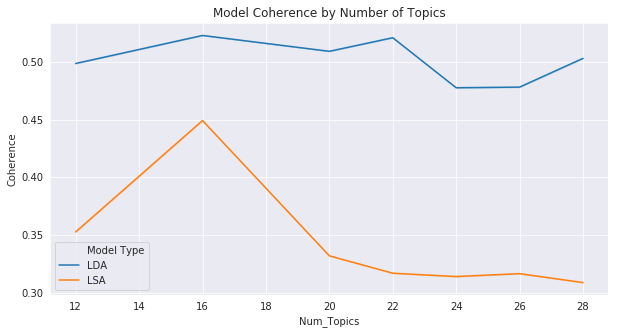

In [30]:
# Compare topic models
plt.figure(figsize=(10, 5))

sns.lineplot(x='Num_Topics', 
             y='Coherence', 
             hue='Model Type', 
             data=model_info)
plt.title('Model Coherence by Number of Topics')

plt.show()

## Topics Worth Keeping
Though I tried dropping parts of speech and modal verbs that would not contribute to determining the topic, the model still generated a few topics based on keywords too generic to provide a meaningful topic. For this reason, I will refrain from assigning topics 1,  7,  8, or 13 as the dominant topic for any essay.

In [0]:
Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda16_model, corpus, id2word)
vis

In [0]:
# Code attributed to:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def format_topics_sentences(ldamodel=lda16_model, corpus=corpus, texts=texts):
    # Init output
    df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus[:-1]]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, 
        # Percent Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            # Prevent dominant topics 7 or 8, they're meaningless
            if j in [0, 1, 2, 3, 4] and topic_num not in [1.0, 7.0, 8.0, 13.0]:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                df = df.append(
                    pd.Series([int(topic_num), 
                               round(prop_topic,4), 
                               topic_keywords]), 
                    ignore_index=True)
                break
                
            else:
                continue
                
    df.columns = ['Dominant_Topic', 
                  'Percent_Contrib', 
                  'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    df = pd.concat([df, contents], axis=1)
    return(df)


topics_df = format_topics_sentences(ldamodel=lda16_model, 
                                    corpus=corpus, 
                                    texts=texts)

# Format
topics_df.reset_index(drop= True, inplace=True)


In [33]:
# Set column names
topics_df.columns = ['Dominant_Topic', 
                     'Topic_Percent_Contrib', 
                     'Keywords', 
                     'Text']

# Create Essay number column
topics_df['Essay'] = sent_df.Essay.unique().tolist()

# Show
topics_df.head(10)

,Dominant_Topic,Topic_Percent_Contrib,Keywords,Text,Essay
0,2.0,0.4361,"water, climate, global, land, country, energy,...","[let, -PRON-, first, begin, what, climate, cha...",0
1,2.0,0.4188,"water, climate, global, land, country, energy,...","[fifth, large, population, country, contribute...",1
2,2.0,0.5574,"water, climate, global, land, country, energy,...","[historical, climate, change, profound, effect...",2
3,2.0,0.5186,"water, climate, global, land, country, energy,...","[great, challenge, earth, face, global, warmin...",3
4,2.0,0.3484,"water, climate, global, land, country, energy,...","[essay, discuss, challenge, global, warming, p...",4
5,5.0,0.1884,"religion, life, woman, marriage, religious, se...","[friendly, taxi, company, found, late, other, ...",5
6,2.0,0.1437,"water, climate, global, land, country, energy,...","[nation, adapt, climate, change, become, key, ...",6
7,2.0,0.4594,"water, climate, global, land, country, energy,...","[assume, -PRON-, year, continuous, temperature...",7
8,2.0,0.5132,"water, climate, global, land, country, energy,...","[fever, fever, rise, -PRON-, what, wrong, -PRO...",8
9,2.0,0.3483,"water, climate, global, land, country, energy,...","[put, -PRON-, simple, term, climate, change, r...",9


In [34]:
pd.options.display.max_rows = 100
# Code attributed to: 
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# Group top 5 essays under each topic
sorted_topics = pd.DataFrame()

grouped = topics_df.groupby('Dominant_Topic')

for i, grp in grouped:
    sorted_topics = pd.concat([sorted_topics, 
                               grp.sort_values(['Topic_Percent_Contrib'], 
                                               ascending=[0]).head(5)], 
                              axis=0)

# Reset Index    
sorted_topics.reset_index(drop=True, inplace=True)

# Format
sorted_topics.columns = ['Topic_Num', 
                         'Topic_Percent_Contrib', 
                         'Keywords', 
                         'Text', 
                         'Essay']

# Show
sorted_topics

,Topic_Num,Topic_Percent_Contrib,Keywords,Text,Essay
0,0.0,0.5504,"child, school, student, bullying, parent, fami...","[bullying, problem, school, long, -PRON-, gain...",379
1,0.0,0.5315,"child, school, student, bullying, parent, fami...","[child, abuse, common, term, type, child, malt...",623
2,0.0,0.5142,"child, school, student, bullying, parent, fami...","[harmful, effect, bullying, suicide, depressio...",699
3,0.0,0.4936,"child, school, student, bullying, parent, fami...","[bullying, become, epidemic, educational, syst...",979
4,0.0,0.4652,"child, school, student, bullying, parent, fami...","[today, society, bullying, play, big, roll, sc...",145
5,2.0,0.6627,"water, climate, global, land, country, energy,...","[nuclear, accident, trigger, large, scale, nuc...",3297
6,2.0,0.6371,"water, climate, global, land, country, energy,...","[climate, change, significant, lasting, change...",18
7,2.0,0.6229,"water, climate, global, land, country, energy,...","[effect, global, climate, change, associate, m...",19
8,2.0,0.6219,"water, climate, global, land, country, energy,...","[link, climate, change, biodiversity, climate,...",20
9,2.0,0.6092,"water, climate, global, land, country, energy,...","[investigate, road, year, -PRON-, today, chang...",6341


## Dominant Topic Distribution

The dominant topics are relatively well distributed once the more generic topics are removed. No one topic dominates the essay and a cursory look confirms the distribution I would expect based on the number of essays I was able to scrape for each topic.

In [35]:
# Number of Documents for Each Topic
topic_counts = topics_df.groupby(
    'Keywords')['Dominant_Topic'].count()
topic_counts

Keywords
change, economic, country, world, political, system, power, new, century, culture                    916
child, school, student, bullying, parent, family, bully, education, young, age                       366
death, penalty, punishment, kill, suicide, murder, life, die, crime, prison                          209
health, care, patient, mental, service, quality, medical, staff, risk, satisfaction                  583
law, police, crime, officer, criminal, justice, gun, enforcement, illegal, force                     419
organization, company, employee, management, business, organizational, market, product, work, new    507
religion, life, woman, marriage, religious, sex, belief, mother, believe, same                       605
right, human, state, government, law, should, people, -PRON-, freedom, society                       960
social, medium, use, information, technology, internet, art, computer, phone, user                   308
water, climate, global, land, country, energy,

In [0]:
# Isolate tags for tokenization and topic modeling
tags = sent_df.groupby('Essay')['Tags'].apply(lambda x: np.unique(x)[0])

In [37]:
# Tokenize tags and prepare for topic model
tokenized_tags =[]

nlp = spacy.load('en')
i = 0
for tag in tags:
    i += 1
    if i % 500 == 0:
        print('Processing {}'.format(i))
    tag = ' '.join(tag)
    doc = nlp(tag)
    # Get lemmas for each word
    tokenized_tags.append([token.lemma_ for token in doc if not token.is_punct])
    
tag_corpus = []
for i in range(len(tokenized_tags)):
    try:
        tag_corpus.append(id2word.doc2bow(tokenized_tags[i]))
    except:
        print('Error: {}'.format(i))


Processing 500
Processing 1000
Processing 1500
Processing 2000
Processing 2500
Processing 3000
Processing 3500
Processing 4000
Processing 4500
Processing 5000
Processing 5500
Processing 6000
Processing 6500


In [38]:
# Get topics for tags
tags_df = format_topics_sentences(ldamodel=lda16_model, 
                                         corpus=tag_corpus, 
                                         texts=tokenized_tags)

tags_df.columns = ['Tag_Topic', 
                   'Tag_Percent_Contrib', 
                   'Tag_Keywords', 
                   'Tags']

tags_df.head()

,Tag_Topic,Tag_Percent_Contrib,Tag_Keywords,Tags
0,2.0,0.1523,"water, climate, global, land, country, energy,...","[climate, change]"
1,2.0,0.1524,"water, climate, global, land, country, energy,...","[climate, change]"
2,2.0,0.1523,"water, climate, global, land, country, energy,...","[climate, change]"
3,2.0,0.1562,"water, climate, global, land, country, energy,...","[War, Global, warming]"
4,2.0,0.1562,"water, climate, global, land, country, energy,...","[War, Global, warming]"


In [39]:
# Add tags and topics to the essay-topic data frame
topics_df = topics_df.join(tags_df)
topics_df.head()

,Dominant_Topic,Topic_Percent_Contrib,Keywords,Text,Essay,Tag_Topic,Tag_Percent_Contrib,Tag_Keywords,Tags
0,2.0,0.4361,"water, climate, global, land, country, energy,...","[let, -PRON-, first, begin, what, climate, cha...",0,2.0,0.1523,"water, climate, global, land, country, energy,...","[climate, change]"
1,2.0,0.4188,"water, climate, global, land, country, energy,...","[fifth, large, population, country, contribute...",1,2.0,0.1524,"water, climate, global, land, country, energy,...","[climate, change]"
2,2.0,0.5574,"water, climate, global, land, country, energy,...","[historical, climate, change, profound, effect...",2,2.0,0.1523,"water, climate, global, land, country, energy,...","[climate, change]"
3,2.0,0.5186,"water, climate, global, land, country, energy,...","[great, challenge, earth, face, global, warmin...",3,2.0,0.1562,"water, climate, global, land, country, energy,...","[War, Global, warming]"
4,2.0,0.3484,"water, climate, global, land, country, energy,...","[essay, discuss, challenge, global, warming, p...",4,2.0,0.1562,"water, climate, global, land, country, energy,...","[War, Global, warming]"


## Topic Accuracy
The topic accuracy rose from about 25% to around 38% when the generic topics were pruned. Still, I believe the main thing holding back the accuracy of the topics to be the fact that my labels (the tags scraped from the websites) were not that descriptive of the essay topics to begin with. Given more time, I would find a way to include the search term with the output of the scraper so I could use that as the label instead of the scraped tags. For now, I will show examples of essays and tags where the topic labels match and examples where they don't match to try to illustrate the issue of poor labels over poor topic models.

In [40]:
# Determine the percentage of essay topics that match their tag topic
matches = np.where(
    topics_df['Dominant_Topic'] == topics_df['Tag_Topic'])[0]

l = len(matches)

print('Tag topic to essay topic accuracy: {}'.format(l/len(topics_df)))

Tag topic to essay topic accuracy: 0.381161328067866


In [41]:
# Separate matches and non-matches
match_df = topics_df.loc[matches]
nonmatch_df = topics_df[~topics_df.index.isin(matches)]

# Show a random sample of matches
match_df.sample(25)

,Dominant_Topic,Topic_Percent_Contrib,Keywords,Text,Essay,Tag_Topic,Tag_Percent_Contrib,Tag_Keywords,Tags
4806,5.0,0.1867,"religion, life, woman, marriage, religious, se...","[religion, everyday, fare, matter, discuss, bu...",4806,5.0,0.1242,"religion, life, woman, marriage, religious, se...",[religion]
2673,12.0,0.2535,"health, care, patient, mental, service, qualit...","[indemnity, insurance, insurer, guarantee, pay...",2673,12.0,0.1959,"health, care, patient, mental, service, qualit...","[health, care]"
3646,14.0,0.2572,"law, police, crime, officer, criminal, justice...","[huge, issue, police, department, face, today,...",3646,14.0,0.1949,"law, police, crime, officer, criminal, justice...","[law, Police]"
1831,10.0,0.4389,"change, economic, country, world, political, s...","[world, today, uni, polar, fact, bring, year, ...",1831,10.0,0.2130,"change, economic, country, world, political, s...","[globalization, world]"
3565,14.0,0.2915,"law, police, crime, officer, criminal, justice...","[stress, part, people, life, profession, pract...",3565,14.0,0.1201,"law, police, crime, officer, criminal, justice...",[Police]
4738,5.0,0.2407,"religion, life, woman, marriage, religious, se...","[novel, various, reference, muslim, tradition,...",4738,5.0,0.1131,"religion, life, woman, marriage, religious, se...","[literature, religion]"
6225,3.0,0.2896,"death, penalty, punishment, kill, suicide, mur...","[death, penalty, -PRON-, justify, young, man, ...",6225,3.0,0.1930,"death, penalty, punishment, kill, suicide, mur...","[death, penalty]"
4645,5.0,0.2968,"religion, life, woman, marriage, religious, se...","[accord, man, who, live, can, bear, -PRON-, st...",4645,5.0,0.1768,"religion, life, woman, marriage, religious, se...","[life, religion]"
3813,9.0,0.2147,"woman, society, group, man, culture, gender, d...","[racism, play, important, role, author, use, r...",3813,9.0,0.1208,"woman, society, group, man, culture, gender, d...","[literature, race]"
1415,10.0,0.3073,"change, economic, country, world, political, s...","[democracy, capitalism, give, way, concentrati...",1415,10.0,0.1495,"change, economic, country, world, political, s...",[democracy]


In [42]:
# Show a random sample of non-matches
nonmatch_df.sample(25)

,Dominant_Topic,Topic_Percent_Contrib,Keywords,Text,Essay,Tag_Topic,Tag_Percent_Contrib,Tag_Keywords,Tags
3725,11.0,0.2173,"social, medium, use, information, technology, ...","[first, start, year, ’s, first, klan, lead, ef...",3725,9.0,0.1257,"woman, society, group, man, culture, gender, d...",[racism]
6705,15.0,0.1665,"organization, company, employee, management, b...","[final, stage, accord, model, involve, put, ch...",6705,10.0,0.0654,"change, economic, country, world, political, s...","[Change, Model]"
4714,10.0,0.2655,"change, economic, country, world, political, s...","[religion, can, define, strong, belief, supern...",4714,5.0,0.1242,"religion, life, woman, marriage, religious, se...",[religion]
6203,9.0,0.2640,"woman, society, group, man, culture, gender, d...","[establish, goal, focus, international, develo...",6203,10.0,0.0590,"change, economic, country, world, political, s...","[literature, Gender]"
487,10.0,0.2168,"change, economic, country, world, political, s...","[gender, analysis, international, relation, ca...",487,6.0,0.1505,"right, human, state, government, law, should, ...","[Gender, politic]"
423,9.0,0.2972,"woman, society, group, man, culture, gender, d...","[feminism, become, range, subtle, attack, male...",423,10.0,0.0654,"change, economic, country, world, political, s...","[Literature, Jane, Austen]"
5485,15.0,0.0999,"organization, company, employee, management, b...","[alight, bus, make, clumsy, half, skip, last, ...",5485,4.0,0.1142,"water, use, drug, solution, food, test, body, ...",[water]
5062,0.0,0.1356,"child, school, student, bullying, parent, fami...","[enormous, amount, people, world, -PRON-, live...",5062,6.0,0.1374,"right, human, state, government, law, should, ...","[culture, ethic]"
1766,2.0,0.2015,"water, climate, global, land, country, energy,...","[modern, industrial, organization, synonymous,...",1766,10.0,0.0654,"change, economic, country, world, political, s...","[Corporation, Globalization]"
3423,15.0,0.0939,"organization, company, employee, management, b...","[say, -PRON-, believe, enough, control, place,...",3423,14.0,0.1201,"law, police, crime, officer, criminal, justice...","[Police, Criminology]"


In [43]:
# Read in the paragraph organization scores or generate them
try:
    score_df = pd.read_csv('score_df.csv')
  
except:
  
    def get_similarity(x, y):
        # Get cosine similarity between sentence vectors
        return x.similarity(y)
  
  # Establish a column for paragraph level scores
    sent_df['Para_score'] = 0

    for i, grp in sent_df.groupby(['Essay', 'Paragraph']):
        idx = grp.index
  
        if i[0] % 500  == 0:
            print('Processing {}'.format(i))
  
        # Set the paragraph level score as the mean of the cosine
        # similarity scores of all combinations of sentences within
        # a paragraph
        sent_df.loc[idx, 'Para_score'] = np.mean([x for x in starmap(
            get_similarity, combinations(grp['Text'], 2))])
  
        if i[0] % 500  == 0:
          print('Para_score {} = {}'.format(idx, sent_df.loc[idx, 'Para_score']))
    
    sent_df.to_csv('score_df.csv')
  
    score_df = sent_df.copy()

score_df.head()

,Unnamed: 0,Paragraph,Tags,Title,URL,Text,Sentences,Essay,Para_score
0,0,1,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Let’s first begin with “what is climate change...,2,0,0.852365
1,1,1,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Climate change is caused by several factors [2]:,2,0,0.852365
2,2,4,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,The average temperature of the Earth’s surfac...,4,0,0.834929
3,3,4,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Global warming [4] – a direct consequence of t...,4,0,0.834929
4,4,4,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,The “credit” for the “greatest contribution” t...,4,0,0.834929


## Paragraph Scores Distribution
The scores based on the average cosine similarity of sentence vectors within the paragraph tends to be a relatively normal distribution close to one with a long left tail. For this reason, I left all words in the sentence rather than reducing it to semantically-relevant lemmas as in the topic model. When the sentences are reduced in that way, it shifts the distribution even closer to one and increases the kurtosis. 

The negative skew seems to come at least in part from paragraphs containing citations/references, headings, websites, or other text that would not contribute to the body of a paragraph. This issue stems again from the data collection method and these are the pieces of text I was unable to filter out in the earlier cleaning and preprocessing.

## Essay Scores Distribution
The distribution of essay scores is similar to that of paragraph scores while clipping some of the tail on the left. This lets me know that the poor paragraph scores were not all concentrated in a few essays.

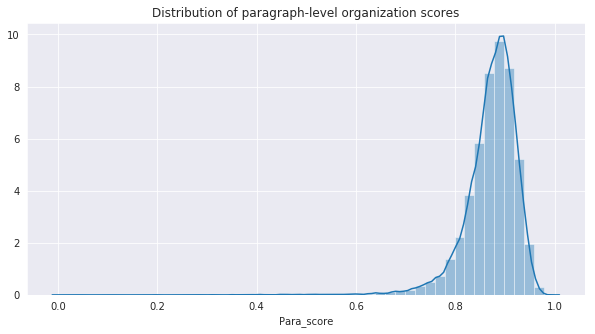

Paragraph Score Min: 0.0
Paragraph Score Max: 0.9980864053273194
Paragraph Score Mean: 0.871710392710698


In [44]:
# Plot the distribution of Paragraph scores
plt.figure(figsize=(10,5))

sns.distplot(score_df['Para_score'])
plt.title('Distribution of paragraph-level organization scores')
plt.show()

print('Paragraph Score Min: {}'.format(score_df['Para_score'].min()))
print('Paragraph Score Max: {}'.format(score_df['Para_score'].max()))
print('Paragraph Score Mean: {}'.format(score_df['Para_score'].mean()))


In [45]:
# Explore paragraphs that comprise the long tail
score_df[score_df['Para_score'] < 0.6]

,Unnamed: 0,Paragraph,Tags,Title,URL,Text,Sentences,Essay,Para_score
575,575,40,"['War', 'Other']",Global warming Essay,https://studymoose.com/global-warming-essay,"But if we allow this to happen, it would be de...",4,13,0.597948
576,576,40,"['War', 'Other']",Global warming Essay,https://studymoose.com/global-warming-essay,it would condemn coming generations to a catas...,4,13,0.597948
577,577,40,"['War', 'Other']",Global warming Essay,https://studymoose.com/global-warming-essay,"Source: An Inconvenient Truth, by Al Gore, p",4,13,0.597948
578,578,40,"['War', 'Other']",Global warming Essay,https://studymoose.com/global-warming-essay,"67 May 26, 2006",4,13,0.597948
1954,1954,9,['Abortion'],Female Foticide Essay,https://studymoose.com/female-foticide-essay,"To add fuel to the fire, unethical sex determi...",2,62,0.049032
1955,1955,9,['Abortion'],Female Foticide Essay,https://studymoose.com/female-foticide-essay,Source: Vivek Chaudhary,2,62,0.049032
2159,2159,20,"['Crime', 'Criminology']",Criminal Justice System in Hong Kong Essay,https://studymoose.com/criminal-justice-system...,New Jersey,2,67,0.379181
2160,2160,20,"['Crime', 'Criminology']",Criminal Justice System in Hong Kong Essay,https://studymoose.com/criminal-justice-system...,Aurora Publishing.,2,67,0.379181
2654,2654,12,"['Bullying', 'Team']",When Bullying Leads to Believing Essay,https://studymoose.com/when-bullying-leads-to-...,started over…and believes it’s time to be forg...,2,92,0.465669
2655,2655,12,"['Bullying', 'Team']",When Bullying Leads to Believing Essay,https://studymoose.com/when-bullying-leads-to-...,Retrieved from:,2,92,0.465669


In [46]:
# Initialize an essay-level organization score column
score_df['Essay_score'] = 0

for i, grp in score_df.groupby('Essay'):
    idx = grp.index
  
    if i % 500 == 0:
        print('Processing {}'.format(i))
  
  # Set essay score to the mean of paragraph-level organization scores
    score_df.loc[idx, 'Essay_score'] = np.mean(
      [x for x in grp['Para_score'].unique()])
  
    
score_df.head()

Processing 0
Processing 500
Processing 1000
Processing 1500
Processing 2000
Processing 2500
Processing 3000
Processing 3500
Processing 4000
Processing 4500
Processing 5000
Processing 5500
Processing 6000
Processing 6500


,Unnamed: 0,Paragraph,Tags,Title,URL,Text,Sentences,Essay,Para_score,Essay_score
0,0,1,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Let’s first begin with “what is climate change...,2,0,0.852365,0.870182
1,1,1,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Climate change is caused by several factors [2]:,2,0,0.852365,0.870182
2,2,4,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,The average temperature of the Earth’s surfac...,4,0,0.834929,0.870182
3,3,4,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Global warming [4] – a direct consequence of t...,4,0,0.834929,0.870182
4,4,4,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,The “credit” for the “greatest contribution” t...,4,0,0.834929,0.870182


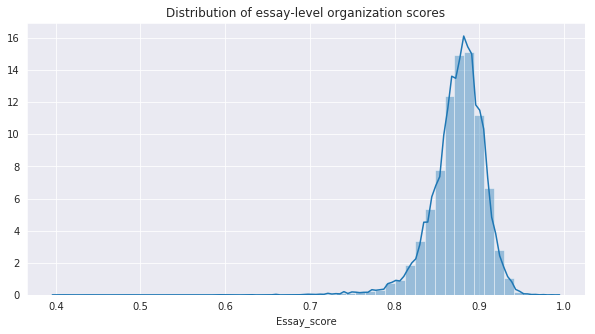

Essay Score Min: 0.4032206824820646
Essay Score Max: 0.9873634292619194
Essay Score Mean: 0.8746106984248522


In [47]:
# Plot the distribution of Essay scores
plt.figure(figsize=(10,5))

sns.distplot(score_df['Essay_score'])
plt.title('Distribution of essay-level organization scores')
plt.show()

print('Essay Score Min: {}'.format(score_df['Essay_score'].min()))
print('Essay Score Max: {}'.format(score_df['Essay_score'].max()))
print('Essay Score Mean: {}'.format(score_df['Essay_score'].mean()))

In [48]:
# Scale Essay scores based on their z-score
scaler = StandardScaler()

score_df['z_score'] = scaler.fit_transform(
    np.array(score_df['Essay_score']).reshape(-1,1))

print(score_df['z_score'].min())
print(score_df['z_score'].max())

-15.321677451979214
3.6648230027999493


In [49]:
# Cut of the tails of the Essay z-scores by assigning them to 3 or -3
score_df['z_score'] = score_df['z_score'].apply(lambda x: x if x <= 3 else 3)
score_df['z_score'] = score_df['z_score'].apply(lambda x: x if x > -3 else -3)

print(score_df['z_score'].min())
print(score_df['z_score'].max())

-3.0
3.0


In [50]:
# Add 3 to all z-scores to get rid of negative values
score_df['z_score'] += 3

print(score_df['z_score'].min())
print(score_df['z_score'].max())

0.0
6.0


In [51]:
# Add essay topic coherence scores to the data frame
on_topic_dict = dict(zip(
    topics_df['Essay'], topics_df['Topic_Percent_Contrib']))

score_df['Topic_score'] = score_df['Essay'].replace(on_topic_dict)

score_df.head()

,Unnamed: 0,Paragraph,Tags,Title,URL,Text,Sentences,Essay,Para_score,Essay_score,z_score,Topic_score
0,0,1,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Let’s first begin with “what is climate change...,2,0,0.852365,0.870182,2.856042,0.4361
1,1,1,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Climate change is caused by several factors [2]:,2,0,0.852365,0.870182,2.856042,0.4361
2,2,4,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,The average temperature of the Earth’s surfac...,4,0,0.834929,0.870182,2.856042,0.4361
3,3,4,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Global warming [4] – a direct consequence of t...,4,0,0.834929,0.870182,2.856042,0.4361
4,4,4,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,The “credit” for the “greatest contribution” t...,4,0,0.834929,0.870182,2.856042,0.4361


In [52]:
# Scale essay topic coherence scores between 0 and 1
mmscaler = MinMaxScaler()

score_df['on_topic'] = mmscaler.fit_transform(
    np.array(score_df['Topic_score']).reshape(-1,1))

# Get a final organization score by mutliplying the essay org z-score
# by the essay topic coherence score
score_df['Org_score'] = score_df['z_score'] * score_df['on_topic']

score_df.head()

,Unnamed: 0,Paragraph,Tags,Title,URL,Text,Sentences,Essay,Para_score,Essay_score,z_score,Topic_score,on_topic,Org_score
0,0,1,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Let’s first begin with “what is climate change...,2,0,0.852365,0.870182,2.856042,0.4361,0.645666,1.844048
1,1,1,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Climate change is caused by several factors [2]:,2,0,0.852365,0.870182,2.856042,0.4361,0.645666,1.844048
2,2,4,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,The average temperature of the Earth’s surfac...,4,0,0.834929,0.870182,2.856042,0.4361,0.645666,1.844048
3,3,4,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Global warming [4] – a direct consequence of t...,4,0,0.834929,0.870182,2.856042,0.4361,0.645666,1.844048
4,4,4,['Climate change'],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,The “credit” for the “greatest contribution” t...,4,0,0.834929,0.870182,2.856042,0.4361,0.645666,1.844048


In [0]:
# Drop the one essay with null values
score_df.dropna(how='any', axis=0, inplace=True)

## Final Organization Score
The topic model is not perfect, so the distribution of final organization scores (comprised of essay-level org z-scores with the tails clipped and made positive times topic contrib scores scaled between 0 and 1) did not end up on a 0 - 6 scale as I had hoped. However, it seemed to me there was a way to divide the distribution of organization scores to give it the types of grades teachers might give to their students on for essay organization. 

- 0 -- This writer cannot demonstrate having learned about organization
-1 -- This writer demonstrates minimal organization -- the essay is divided into paragraphs, some remain on topic
- 2 -- This writer is approaching sufficient organization -- many paragraphs remain on topic
- 3 -- This writer is proficient at organization -- nearly all paragraphs are on topic and contribute to the thesis
- 4 -- This writer is has advanced organization -- all paragraphs remain on topic and contribute to the thesis

As with the topic model accuracy, I will have to pull out examples to qualitatively determine whether these labels are accurate.

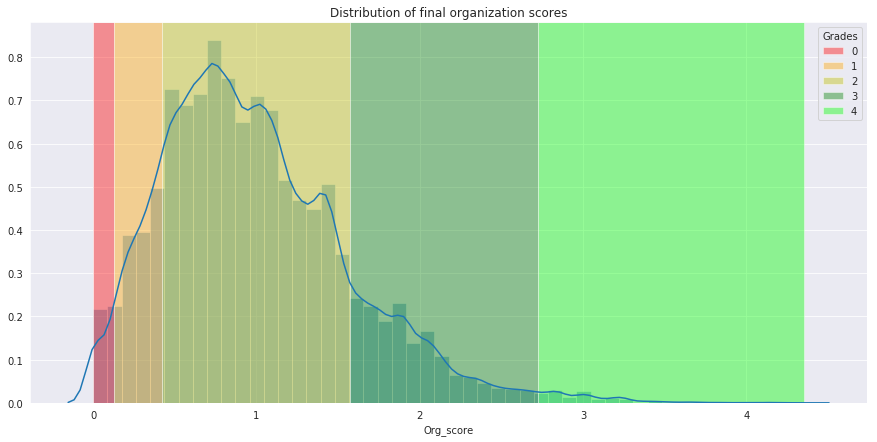

Minimum: 0.0
Maximum: 4.35343155064282
Mean: 0.9958512232352045
Standard Deviation: 0.5770847264990766


In [54]:
# Plot the distribution of Organization scores
m = score_df['Org_score'].mean()
maximum = score_df['Org_score'].max()
minimum = score_df['Org_score'].min()
std = score_df['Org_score'].std()

plt.figure(figsize=(15,7))

sns.distplot(score_df['Org_score'])

# Assign teacher interpretable scores -- "Grade on a curve"
plt.axvspan(minimum, (m-(1.5*std)), facecolor='r', alpha=0.4, label='0')
plt.axvspan((m-(1.5*std)), (m-std), facecolor='orange', alpha=0.4, label='1')
plt.axvspan((m-std), (m+std), facecolor='y', alpha=0.4, label='2')
plt.axvspan((m+std), (m+(3*std)), facecolor='g', alpha=0.4, label='3')
plt.axvspan((m+(3*std)), maximum, facecolor='lime', alpha=0.4, label='4')

plt.legend(title='Grades')

plt.title('Distribution of final organization scores')
plt.show()

print('Minimum: {}'.format(minimum))
print('Maximum: {}'.format(maximum))
print('Mean: {}'.format(m))
print('Standard Deviation: {}'.format(std))

In [0]:
# Sample best, average, and worst essays
expert = score_df[score_df['Org_score']>3]
average = score_df[score_df['Org_score']<1.1]
average = average[average['Org_score']>0.8]
worst = score_df[score_df['Org_score']<0.25]

# Show a random sample of matches
ex_sample = expert.sample(25)['URL'].tolist()
av_sample = average.sample(25)['URL'].tolist()
w_sample = worst.sample(25)['URL'].tolist()

In [56]:
print('Expert essays:\n')
for url in ex_sample:
    print(url + '\n')
print('\n\nAverage essays:\n')
for url in av_sample:
    print(url + '\n')
print('\n\nBad essays:\n')
for url in w_sample:
    print(url + '\n')

Expert essays:

https://studymoose.com/the-benefits-of-democracy-essay

https://phdessay.com/climate-change-solutions/

https://studymoose.com/ethical-egoism-and-capitalism-essay

https://studymoose.com/the-power-of-religion-essay

https://studymoose.com/how-economic-globalization-has-fostered-globalization-of-critics-and-criticism-essay

https://studymoose.com/the-power-of-religion-essay

https://studymoose.com/the-fukushima-nuclear-power-plant-accident-essay

https://studymoose.com/the-fukushima-nuclear-power-plant-accident-essay

https://studymoose.com/the-power-of-religion-essay

https://studymoose.com/the-power-of-religion-essay

https://studymoose.com/how-economic-globalization-has-fostered-globalization-of-critics-and-criticism-essay

https://studymoose.com/how-economic-globalization-has-fostered-globalization-of-critics-and-criticism-essay

https://phdessay.com/climate-change-solutions/

https://studymoose.com/to-paint-a-water-lily-by-ted-hughes-essay

https://studymoose.com/th

## Conclusions
This is not a fantastic model, but it is a start. Some of the challenges that I faced in getting good results from this model stem from the lack of meaningful labels generated by experts, poor paragraph delineations from the method of data collection, and the inability to remove all citations/references and other non-semantically-relevant text.

For future iterations, I will address these challenges by collecting labeled essays from teachers through an online form, asking that they upload only the text of the essay and using code to try to confirm that, and if possible have them denote the thesis statement as the topic against which to compare on-topic coherence. 